# A High-Level Introduction to Graph Convolutional Networks

> [**How to do Deep Learning on Graphs with Graph Convolutional Networks** Part 1: A High-Level Introduction to Graph Convolutional Networks](https://towardsdatascience.com/how-to-do-deep-learning-on-graphs-with-graph-convolutional-networks-7d2250723780)

## 2. A Simple Graph Example
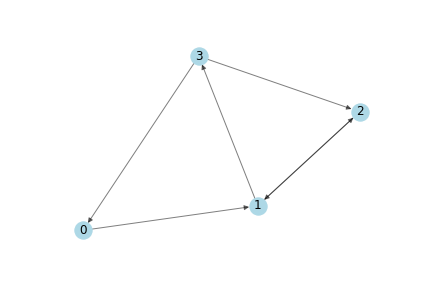

A simple directed graph:
- 0 -> 1
- 1 -> 2, 1 -> 3
- 2 -> 1
- 3 -> 0, 3 -> 2

In [4]:
import numpy as np

# adjacency matrix
A = np.array([
    [0, 1, 0, 0],
    [0, 0, 1, 1],
    [0, 1, 0, 0],
    [1, 0, 1, 0]
], dtype=float)
print('adjacency matrix: ')
print(A)
print()

# feature matrix (2 integer features for every node based on its index)
X = np.array([
    [i, -i] for i in range(A.shape[0])
], dtype=float)
print('feature matrix: ')
print(X)

adjacency matrix: 
[[0. 1. 0. 0.]
 [0. 0. 1. 1.]
 [0. 1. 0. 0.]
 [1. 0. 1. 0.]]

feature matrix: 
[[ 0.  0.]
 [ 1. -1.]
 [ 2. -2.]
 [ 3. -3.]]


### 2.1 Propagation Rule 
$$f(X,A) = AX$$
- The representation of each node (each row) is now a sum of its neighbors features!
- The graph convolutional layer represents each node as an aggregate of its neighborhood.
- **Note**: a node n is a neighbor of node v if there exists an edge from v to n.

In [5]:
print('A.*X: ')
print(np.matmul(A, X))

A.*X: 
[[ 1. -1.]
 [ 5. -5.]
 [ 1. -1.]
 [ 2. -2.]]


### 2.2 Problems:
1. The aggregated representation of a node does not include its own features! Only nodes that has a self-loop will include their own features in the aggregate.
2. Nodes with large degrees will have large values in their feature representation otherwise the opposite. This can cause vanishing or exploding gradients.

### 2.3 Solutions:
1. Adding Self-Loops

    - In practice this is done by adding the identity matrix $I$ to the adjacency matrix $A$ before applying the propagation rule.

In [12]:
I = np.eye(A.shape[0])
A_s = A + I
print(A_s.dot(X))

[[ 1. -1.]
 [ 6. -6.]
 [ 3. -3.]
 [ 5. -5.]]


2. Normalizing the Feature Representations

    - Transform the adjacency matrix A by multiplying it with the inverse degree matrix D
$$ f(X,A) = D^{-1}AX $$

In [13]:
D = np.array(np.sum(A, axis=0))
D = np.array(np.diag(D))
print('degree matrix: ')
print(D)
print()
print('transformed adjacency matrix: ')
print(np.linalg.inv(D).dot(A))
print()
print(np.linalg.inv(D).dot(A).dot(X))

degree matrix: 
[[1. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 1.]]

transformed adjacency matrix: 
[[0.  1.  0.  0. ]
 [0.  0.  0.5 0.5]
 [0.  0.5 0.  0. ]
 [1.  0.  1.  0. ]]

[[ 1.  -1. ]
 [ 2.5 -2.5]
 [ 0.5 -0.5]
 [ 2.  -2. ]]


3. Putting it All Together

In [14]:
# D_s is the degree matrix of A_s=A + I
D_s = np.array(np.sum(A_s, axis=0))
D_s = np.array(np.diag(D_s))
print(np.linalg.inv(D_s).dot(A_s).dot(X))

[[ 0.5 -0.5]
 [ 2.  -2. ]
 [ 1.  -1. ]
 [ 2.5 -2.5]]


4. Adding back the Weights and an Activation Function

In [16]:
def relu(arr):
    return arr[arr<0] = 0
    
W = np.array([
    [1, -1],
    [-1, 1]
])
print(relu(np.linalg.inv(D_s).dot(A_s).dot(X).dot(W)))

[[1. 0.]
 [4. 0.]
 [2. 0.]
 [5. 0.]]


## 3. Node Embeddings with Random Weights

> Corresponding to Appendix A.1 of *Semi-Supervised Classification with Graph Convolutional Networks* by Thomas Kipf and Max Welling

- Zachary’s karate club social network with its nodes represent members of a karate club and the edges their mutual relations. The `administrator` and `instructor` are marked with ‘A’ and ‘I’ respectively.

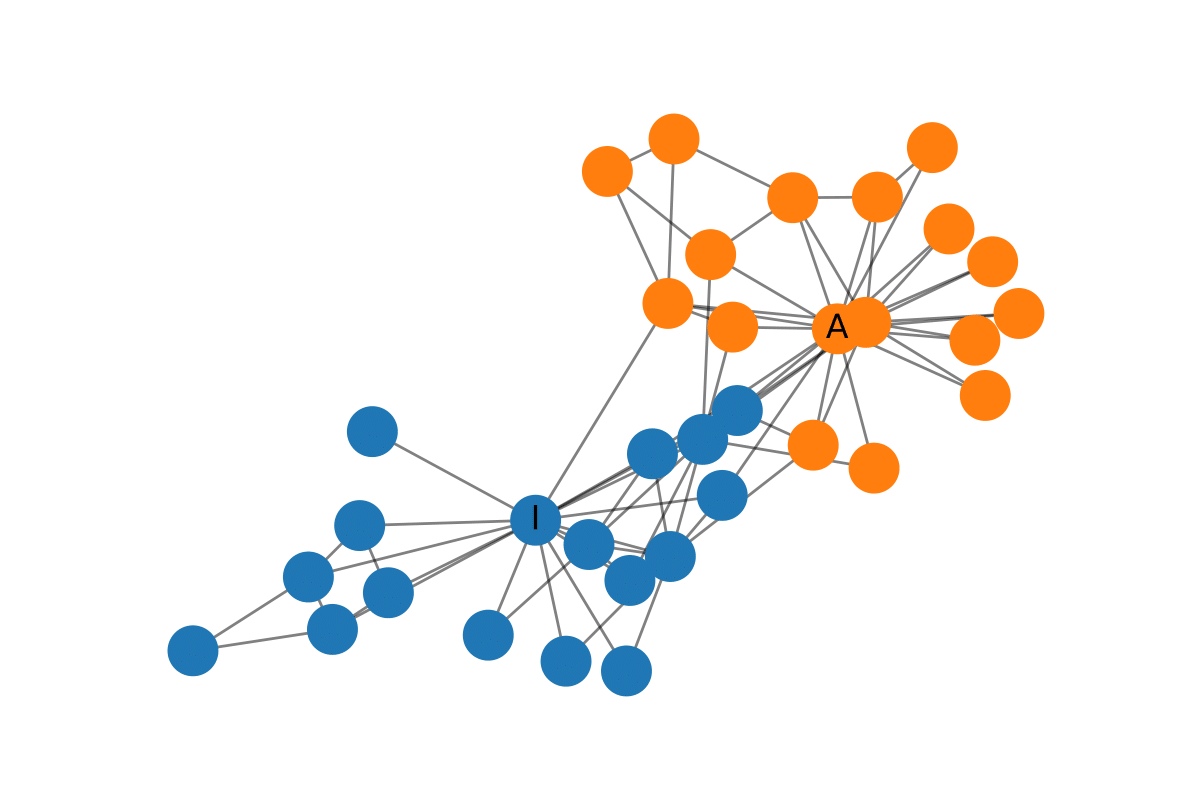

### 3.1 Introducing the Graph

In [35]:
from networkx import karate_club_graph, to_numpy_matrix
zkc = karate_club_graph()
order = sorted(list(zkc.nodes()))
Adj = to_numpy_matrix(zkc, nodelist=order)
I = np.eye(zkc.number_of_nodes())
Adj_norm = Adj + I
D_hat = np.array(np.sum(Adj_norm, axis=0))[0]
D_hat = np.array(np.diag(D_hat))

### 3.2 Building the GCN
- use the identity matrix $I$ as feature representation e.g., each node is represented as a one-hot encoded categorical variable.
- initialize weights randomly

In [72]:
def gcn_layer(A_norm, D_hat, X, W):
    return relu(np.linalg.inv(D_hat).dot(A_norm).dot(X).dot(W))

inputFeature = I
W_1 = np.random.normal(loc=0, scale=1, size=(zkc.number_of_nodes(), 4))
W_2 = np.random.normal(loc=0, size=(W_1.shape[1], 2))

# stack GCN layers
H_1 = gcn_layer(Adj_norm, D_hat, inputFeature, W_1)
H_2 = gcn_layer(Adj_norm, D_hat, H_1, W_2)

output = np.array(H_2)

### 3.3 Visualizing the Output Hidden Layer

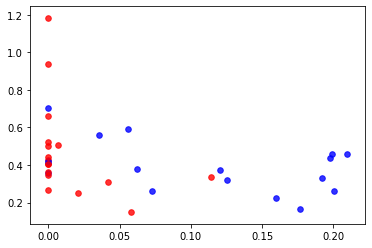

In [73]:
import matplotlib.pyplot as plt 

feature_representations = {
    node: output[node] 
    for node in zkc.nodes()}

for i,em in feature_representations.items():
    if zkc.nodes[i]['club'] == 'Mr. Hi':
        plt.scatter(em[0],em[1] ,color = 'b', alpha=0.8, s = np.pi*10)
    else:
        plt.scatter(em[0],em[1] ,color = 'r', alpha=0.8, s = np.pi*10)